In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # 添加这行
import re

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
# metric in long-term-forecasting
# mae, mse, rmse, mape, mspe

In [3]:
path = './results_long_term_forecasting'
datasets = sorted(os.listdir(os.path.join(path, f'resultsGym_TSFM')))
result_dict, runtime_dict = {}, {}
for dataset in datasets:
    result_dict[dataset], runtime_dict[dataset] = {}, {}
    pred_lens = [96, 192, 336, 720] if dataset not in ['ili', 'fred-md', 'covid-19'] else [24, 36, 48, 60]
    for pred_len in pred_lens:
        file_list = os.listdir(os.path.join(path, f'resultsGym_non_transformer', dataset)) +\
                    os.listdir(os.path.join(path, f'resultsGym_transformer', dataset)) +\
                    os.listdir(os.path.join(path, f'resultsGym_LLM', dataset)) +\
                    os.listdir(os.path.join(path, f'resultsGym_TSFM', dataset))
        file_list = [_ for _ in file_list if f'pl{pred_len}' in _]
        result_dict[dataset][pred_len], runtime_dict[dataset][pred_len] = {}, {}
        for file in file_list:
            try:
                result = np.load(os.path.join(path, f'resultsGym_non_transformer', dataset, file, 'metrics.npy'), allow_pickle=True)
            except:
                try:
                    result = np.load(os.path.join(path, f'resultsGym_transformer', dataset, file, 'metrics.npy'), allow_pickle=True)
                except:
                    try:
                        result = np.load(os.path.join(path, f'resultsGym_LLM', dataset, file, 'metrics.npy'), allow_pickle=True)
                    except:
                        try:
                            result = np.load(os.path.join(path, f'resultsGym_TSFM', dataset, file, 'metrics.npy'), allow_pickle=True)
                        except:
                            continue
            result_dict[dataset][pred_len][file] = result[1]

In [4]:
metrics_dict = {}
model_names = ['non_Transformer', 'Transformer', 'LLM', 'TSFM']
for dataset in datasets:
    metrics_dict[dataset] = {}
    pred_lens = [96, 192, 336, 720] if dataset not in ['ili', 'fred-md', 'covid-19'] else [24, 36, 48, 60]

    for model_name in model_names:
        metrics_dict[dataset][model_name] = {}
        mus, stds = [], []
        for pred_len in pred_lens:
            if model_name == 'non_Transformer':
                metrics = [v for k, v in result_dict[dataset][pred_len].items() if 'MLP' in k or 'GRU' in k]
            else:
                metrics = [v for k, v in result_dict[dataset][pred_len].items() if model_name in k]

            
            if len(metrics) == 0:
                mu, std = np.nan, np.nan
            else:
                mu, std = np.mean(metrics), np.std(metrics)

            mus.append(mu)
            stds.append(std)
        metrics_dict[dataset][model_name] = [np.array(mus), np.array(stds)]

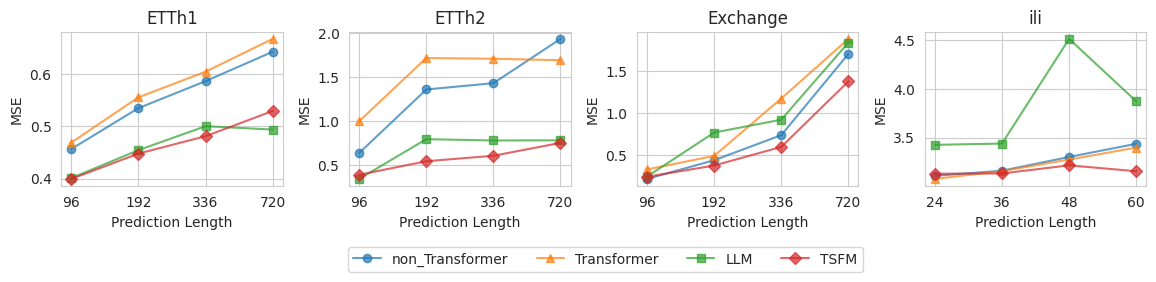

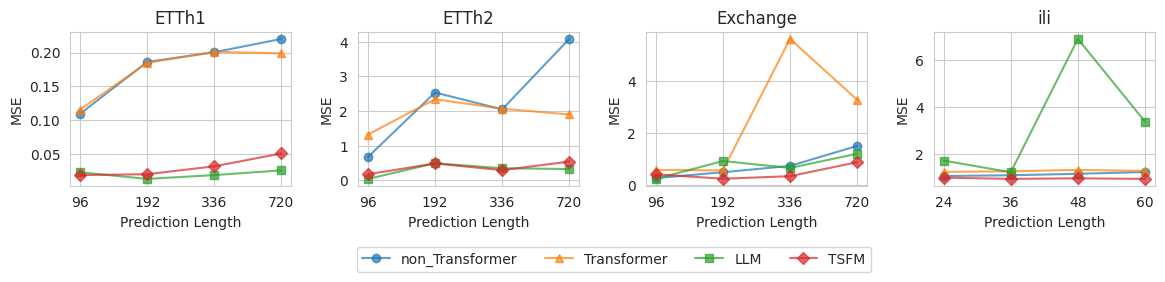

In [5]:
markers = ['o', '^', 's', 'D']
fig = plt.figure(figsize=(14, 2))
for i, dataset in enumerate(datasets):
    fig.add_subplot(1, 4, i+1)
    pred_lens = [96, 192, 336, 720] if dataset not in ['ili', 'fred-md', 'covid-19'] else [24, 36, 48, 60]

    for j, model_name in enumerate(model_names):
        plt.plot(metrics_dict[dataset][model_name][0], label=model_name, marker=markers[j], ms=6, alpha=0.7)
        # plt.fill_between(range(4),
        #                  metrics_dict[dataset][model_name][0]-metrics_dict[dataset][model_name][1],
        #                  metrics_dict[dataset][model_name][0]+metrics_dict[dataset][model_name][1],
        #                  alpha=0.2, label='Std')
        # plt.errorbar(range(4), metrics_dict[dataset][model_name][0],
        #               metrics_dict[dataset][model_name][1], linestyle='None', marker='^', alpha=0.5)

    plt.xlabel('Prediction Length')
    plt.xticks(range(4), pred_lens)
    plt.ylabel('MSE')
    if i == 0: plt.legend(bbox_to_anchor=(3.65, -0.35), ncol=4)
    plt.title(dataset)

plt.subplots_adjust(wspace=0.3)
plt.savefig(f'./notebooks/vis/mu.pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

fig = plt.figure(figsize=(14, 2))
for i, dataset in enumerate(datasets):
    fig.add_subplot(1, 4, i+1)
    pred_lens = [96, 192, 336, 720] if dataset not in ['ili', 'fred-md', 'covid-19'] else [24, 36, 48, 60]

    for j, model_name in enumerate(model_names):
        plt.plot(metrics_dict[dataset][model_name][1], label=model_name, marker=markers[j], ms=6, alpha=0.7)

    plt.xlabel('Prediction Length')
    plt.xticks(range(4), pred_lens)
    plt.ylabel('MSE')
    if i == 0: plt.legend(bbox_to_anchor=(3.65, -0.35), ncol=4)
    plt.title(dataset)

plt.subplots_adjust(wspace=0.3)
plt.savefig(f'./notebooks/vis/std.pdf', bbox_inches='tight', dpi=300)
plt.show()